In [1]:
# libraries to display df and images
from IPython.display import display
from PIL import Image
from pprint import pprint
from tqdm.notebook import tqdm
tqdm.pandas()

# For vizualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from scipy.sparse import hstack as hs
import statsmodels as sm
from pylab import *

# Inbuilt library to work with textual data
import string
import re

# Setting up the NLTK to pre-processing textual data
import spacy
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

!pip install contractions
import contractions
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('universal_tagset')
nltk.download('treebank')

# Ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DonorsChoose/Datasets/Processed Data/Processed_data_final.csv")
df.head(2)

,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,teacher_number_of_previously_posted_projects,project_submitted_month,project_submitted_year,teacher_gender,price,project_essay,project_is_approved,processed_project_essay,processed_project_title,processed_project_subject_categories,processed_project_subject_subcategories
0,IN,grades_prek-2,Literacy_Language,ESL Literacy,Educational Support for English Learners at Home,0,12,2016,Female,4.445,My students are English learners that are work...,0,student english learner work english second la...,educational support english learner home,literacy language,esl literacy
1,FL,grades_6-8,History_Civics Health_Sports,Civics_Government Team_Sports,Wanted: Projector for Hungry Learners,7,10,2016,Male,5.700,Our students arrive to our school eager to lea...,1,student arrive school eager learn polite gene...,want projector hungry learner,history civic health sport,civics government team sport


After a thorough EDA, taking into account the following details we can drop the columns below.

1.   evaluated correlation/collinearity among the features
2.   importance of the features towards the target variable
3.   skewness of data related to a single feature(removed to avoid bias)


In [3]:
cols = [ 'project_subject_categories', 'project_subject_subcategories', 'project_title','project_essay']
df.drop(cols, axis=1, inplace=True)

In [4]:
df.head(2)

,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_submitted_month,project_submitted_year,teacher_gender,price,project_is_approved,processed_project_essay,processed_project_title,processed_project_subject_categories,processed_project_subject_subcategories
0,IN,grades_prek-2,0,12,2016,Female,4.445,0,student english learner work english second la...,educational support english learner home,literacy language,esl literacy
1,FL,grades_6-8,7,10,2016,Male,5.700,1,student arrive school eager learn polite gene...,want projector hungry learner,history civic health sport,civics government team sport


In [5]:
df.shape

(107035, 12)

In [6]:
# Missing value treatment: checking null values in the data
df.isnull().sum()/len(df) * 100

school_state                                    0.000000
project_grade_category                          0.000000
teacher_number_of_previously_posted_projects    0.000000
project_submitted_month                         0.000000
project_submitted_year                          0.000000
teacher_gender                                  0.000000
price                                           0.000000
project_is_approved                             0.000000
processed_project_essay                         0.000000
processed_project_title                         0.040174
processed_project_subject_categories            0.000000
processed_project_subject_subcategories         0.772644
dtype: float64

In [7]:
df.fillna('', inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107035 entries, 0 to 107034
Data columns (total 12 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   school_state                                  107035 non-null  object 
 1   project_grade_category                        107035 non-null  object 
 2   teacher_number_of_previously_posted_projects  107035 non-null  int64  
 3   project_submitted_month                       107035 non-null  int64  
 4   project_submitted_year                        107035 non-null  int64  
 5   teacher_gender                                107035 non-null  object 
 6   price                                         107035 non-null  float64
 7   project_is_approved                           107035 non-null  int64  
 8   processed_project_essay                       107035 non-null  object 
 9   processed_project_title                       10

In [9]:
# Change the dtype for categorical random variables
df = df.astype({"school_state":'category', "project_grade_category":'category' ,"project_submitted_month":'category',"project_submitted_year":'category',"teacher_gender":'category'})

- Perform Binary/Label Encoding for categorical variables `project_submitted_year`, `teacher_gender`.

In [10]:
# teacher_gender
teacher_gender_mapping = {'Male': 0 , 'Female': 1, 'Other':2}
df['teacher_gender'] = df['teacher_gender'].map(teacher_gender_mapping)

# project_submitted_year
df['project_submitted_year'] = df['project_submitted_year'].apply(lambda x: 0 if x==2016 else 1)

#### Data Preparation

In [11]:
# Defining X and Y
X = df[df.columns.drop("project_is_approved")]
y = df["project_is_approved"]

In [12]:
# train-val-test split
from sklearn.model_selection import train_test_split

X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.3, random_state=3, stratify=y)
print(f"Shape of the Train set: {X_train_cv.shape} and Shape of the Test set: {X_test.shape}." )

Shape of the Train set: (74924, 11) and Shape of the Test set: (32111, 11).


- Apply Tf-Idf and one-hot encoding for feature extraction of textual columns.

In [13]:
def tf_idf_encoding_process(df_train, df_test):

  from scipy.sparse import hstack as hs
  # Using inbuilt TfidfVectorizer() function to calculate TF-IDF
  from sklearn.feature_extraction.text import TfidfVectorizer

  # Instantiate the vectorizer object
  tf_idf_vectorizer = TfidfVectorizer(min_df=5)

  # For the column processed_project_title
  train_tfidf_matrix_title = tf_idf_vectorizer.fit_transform(df_train['processed_project_title'])
  test_tfidf_matrix_title = tf_idf_vectorizer.transform(df_test['processed_project_title'])

  # For the column processed_project_essay
  train_tfidf_matrix_essay = tf_idf_vectorizer.fit_transform(df_train['processed_project_essay'])
  test_tfidf_matrix_essay = tf_idf_vectorizer.transform(df_test['processed_project_title'])

  # For the column processed_project_subject_categories
  train_tfidf_matrix_cat = tf_idf_vectorizer.fit_transform(df_train['processed_project_subject_categories'])
  test_tfidf_matrix_cat = tf_idf_vectorizer.transform(df_test['processed_project_subject_categories'])

  # For the column processed_project_subject_subcategories
  train_tfidf_matrix_subcat = tf_idf_vectorizer.fit_transform(df_train['processed_project_subject_subcategories'])
  test_tfidf_matrix_subcat = tf_idf_vectorizer.transform(df_test['processed_project_subject_subcategories'])

  # Display the shapes of the sparse matrices
  print("Train tfidf:", train_tfidf_matrix_title.shape, train_tfidf_matrix_essay.shape, train_tfidf_matrix_cat.shape, train_tfidf_matrix_subcat.shape)
  print("Test tfidf:", test_tfidf_matrix_title.shape, test_tfidf_matrix_essay.shape, test_tfidf_matrix_cat.shape, test_tfidf_matrix_subcat.shape)

  # Stack the transformed values of each set into a single sparse matrix
  train_tf_idf_mat = hs((train_tfidf_matrix_title, train_tfidf_matrix_essay, train_tfidf_matrix_cat, train_tfidf_matrix_subcat))
  test_tf_idf_mat = hs((test_tfidf_matrix_title, test_tfidf_matrix_essay, test_tfidf_matrix_cat, test_tfidf_matrix_subcat))

  # Prepare the matrix for each set after tf-idf has been applied to the required features
  df_train_tf_idf = hs((df_train[['teacher_number_of_previously_posted_projects', 'project_submitted_month', 'project_submitted_year',	'teacher_gender', 'price']].values, train_tf_idf_mat))
  df_test_tf_idf = hs((df_test[['teacher_number_of_previously_posted_projects', 'project_submitted_month', 'project_submitted_year',	'teacher_gender', 'price']].values, test_tf_idf_mat))
  print(f"Train tfidf: {df_train_tf_idf.shape}; Test tfidf: {df_test_tf_idf.shape}")

  return df_train_tf_idf, df_test_tf_idf

- Perform one-hot encoding on other nominal categorical variables

In [14]:
def one_hot_encoding_process(df_train, df_test):

  from scipy.sparse import hstack as hs
  # Using inbuilt CountVectorizer() function to do one-hot encoding on the required features
  from sklearn.feature_extraction.text import CountVectorizer

  # Instantiate the countvectorizer object
  vect = CountVectorizer()

  # For the column school_state
  train_school_one_hot = vect.fit_transform(df_train['school_state'].values)
  test_school_one_hot = vect.transform(df_test['school_state'].values)

  # For the column project_grade_category
  vect = CountVectorizer()
  train_grade_one_hot = vect.fit_transform(df_train['project_grade_category'].values)
  test_grade_one_hot = vect.transform(df_test['project_grade_category'].values)

  # Stack the transformed values of each set into a single sparse matrix
  df_train_one_hot = hs(( train_school_one_hot, train_grade_one_hot))
  df_test_one_hot = hs((test_school_one_hot, test_grade_one_hot))

  # Display the shapes of the sparse matrices
  print(f"Train one-hot:{df_train_one_hot.shape};  Test one-hot:{df_test_one_hot.shape}")

  return df_train_one_hot, df_test_one_hot

In [15]:
# Apply TfIdf and Count Vectorizer to the required categorical features and obtain the transformed X_train_fin, X_test_fin to use for modelling

X_train_tf_idf, X_test_tf_idf = tf_idf_encoding_process(X_train_cv, X_test)
X_train_one_hot, X_test_one_hot = one_hot_encoding_process(X_train_cv, X_test)

Train tfidf: (74924, 3287) (74924, 16640) (74924, 18) (74924, 47)
Test tfidf: (32111, 3287) (32111, 16640) (32111, 18) (32111, 47)
Train tfidf: (74924, 19997); Test tfidf: (32111, 19997)
Train one-hot:(74924, 56);  Test one-hot:(32111, 56)


In [16]:
from scipy.sparse import hstack as hs
X_train_fin = hs((X_train_one_hot, X_train_tf_idf))
X_test_fin = hs((X_test_one_hot, X_test_tf_idf))

print(f"Train Final: {X_train_fin.shape}; Test Final: {X_test_fin.shape}")

Train Final: (74924, 20053); Test Final: (32111, 20053)


#### Training

Baseline - using class imbalance with Logistic Regression:  <br>
- Best validation Accuracy: 0.74900733404961  <br>
- Test Accuracy: 0.7526042883169057 <br>
- roc-auc = 0.6119873650832763


#### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Calculate class weights to account for class imbalance
class_weights = {0: 1/0.2, 1: 1/0.8}  # Manually calculate the inverse of class frequencies

# Instantiate the model object
scaler = StandardScaler(with_mean=False)
logistic = LogisticRegression(class_weight=class_weights, random_state=6)

# Create a pipeline with StandardScaler and Multinomial Naive Bayes
pipeline = Pipeline([('scaler', scaler), ('logistic_reg', logistic)])

# Define the parameter grid for grid search
C = np.logspace(-5, 5, 50)
param_grid = {'logistic_reg__C': C}  # Add more values if needed

# Create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=-1, error_score='raise')

# Train the model with weighted samples and perform grid search
grid_search.fit(X_train_fin, y_train_cv, logistic_reg__sample_weight=np.vectorize(class_weights.get)(y_train_cv))

# Get the best alpha value from the grid search
best_C = grid_search.best_params_['logistic_reg__C']

print('Best C:', grid_search.best_estimator_.get_params()['logistic_reg__C'])
print("Best score: (ROC-AUC score=%0.3f)" % grid_search.best_score_)

# Train the final model with the best alpha and weighted samples
final_model = pipeline.set_params(logistic_reg__C=best_C)
final_model.fit(X_train_fin, y_train_cv, logistic_reg__sample_weight=np.vectorize(class_weights.get)(y_train_cv))

# Make predictions on the test set
y_pred = final_model.predict(X_test_fin)

Best C: 1e-05
Best score: (ROC-AUC score=0.673)


#### Evaluation of Classification Metrics

ROC-AUC Curce

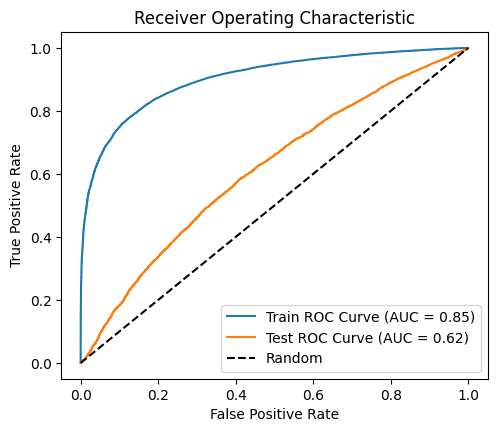

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Make predictions on train and test set probabilities
y_train_probs = final_model.predict_proba(X_train_fin)[:, 1]
y_test_probs = final_model.predict_proba(X_test_fin)[:, 1]

# Calculate ROC-AUC scores
train_roc_auc = roc_auc_score(y_train_cv, y_train_probs)
test_roc_auc = roc_auc_score(y_test, y_test_probs)

# Calculate ROC curves
train_fpr, train_tpr, _ = roc_curve(y_train_cv, y_train_probs)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_probs)

# Plot ROC curves
plt.figure(figsize=(5.5, 4.5))
plt.plot(train_fpr, train_tpr, label='Train ROC Curve (AUC = {:.2f})'.format(train_roc_auc))
plt.plot(test_fpr, test_tpr, label='Test ROC Curve (AUC = {:.2f})'.format(test_roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


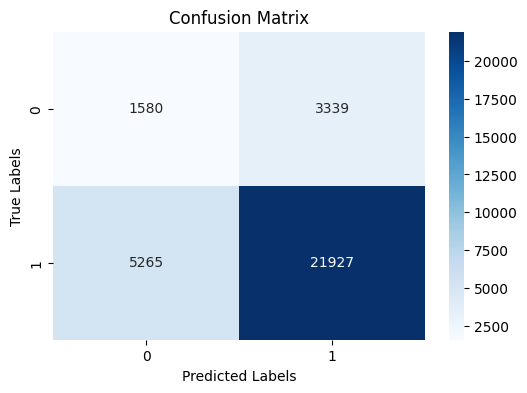

Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.32      0.27      4919
           1       0.87      0.81      0.84     27192

    accuracy                           0.73     32111
   macro avg       0.55      0.56      0.55     32111
weighted avg       0.77      0.73      0.75     32111



In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test set
y_pred = final_model.predict(X_test_fin)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Display the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))
